In [69]:
import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [70]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode='ansi')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))


#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
next_state, reward, done, _, _ = env.step(1)
print("decoded state")
print(list(env.decode(next_state)))

#Render the environment
env.render()

33
decoded state
[0, 1, 3, 1]
500
6
decoded state
[0, 1, 3, 1]


'+---------+\n|R:\x1b \x1b| : :\x1bG\x1b|\n| : | : : |\n| : : : : |\n| | : | : |\n|Y| : |\x1bB\x1b: |\n+---------+\n  (North)\n'

[![Options](https://www.researchgate.net/publication/292208109/figure/fig2/AS:960497125978114@1606011768506/Taxi-problem-and-an-action-hierarchy.gif)]

In [71]:
goal_states = [[0, 0], [0, 4], [4, 0], [4, 3]]
regions = [[[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]], [[0,4],[0,3],[0,2],[1,4],[1,3],[1,2],[2,4],[2,3],[2,2]], [[4,0],[3,0],[2,0],[2,1]], [[4,3],[4,4],[3,3],[3,4],[2,3],[2,4]]]
# regions = [[[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[4,0]], [[0,4],[0,3],[0,2],[1,4],[1,3],[1,2],[2,4],[2,3],[2,2]], [[4,3],[4,4],[3,3],[3,4],[2,3],[2,4]]]

prim_actions = [0, 1, 2, 3, 4, 5]
# actions:  ['down', 'up', 'right', 'left', 'pickup', 'dropoff']

options = [6, 7, 8, 9]
# options: ['goR', 'goG', 'goY', 'goB']
# options = [6, 7, 8]
# options: ['goRY', 'goG', 'goB']


actions = prim_actions+options

Q_select_option = np.zeros((env.observation_space.n, len(actions)))
Q_within_option = np.zeros((len(options), env.observation_space.n, len(prim_actions)-2))

# Softmax function
def softmax(Q, state, tau):
    q_values = Q[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

def epsilon_greedy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(Q[state])
    return action

In [72]:
def decode_state(env, state):
    return list(env.decode(state))

In [73]:
### HYPERPARAMETERS ###
ALPHA_Q = 0.1
ALPHA_OPTIONS = 0.25
ALPHA_OPTIONS_1 = 0.4
GAMMA = 0.99
TAU = 0.1
DECAY_CONSTANT = 0.995

In [74]:
def execute_option(env, state, option, Q_select_option, Q_within_option, select_opt_freq, within_opt_freq, policy=softmax):

    optdone = False

    if option < len(prim_actions):
        next_state, reward, done, _, _ = env.step(option)
        optdone = done
        optact = option
        Q_select_option[state][option] += ALPHA_Q * (reward + GAMMA * np.max(Q_select_option[next_state]) - Q_select_option[state][option])
        select_opt_freq[state][option] += 1

        for opt in options:
            optnum = options.index(opt)
            if optact == np.max(Q_within_option[optnum,state]):
                beta = np.max(Q_select_option[next_state]) if decode_state(env, next_state)[:2] in regions[optnum] else Q_select_option[next_state][opt]
                Q_select_option[state, opt] += ALPHA_Q * (reward - Q_select_option[state, opt] + GAMMA * beta)
        return next_state, reward, done, [Q_select_option, Q_within_option, select_opt_freq, within_opt_freq]
        
    if option >= len(prim_actions):
        reward_bar = 0
        optnum = options.index(option)
        counter = 0
        while optdone == False:
            optact = policy(Q_within_option[optnum], state, TAU)
            next_state, reward, done, _, _ = env.step(optact)

            for idx, opt in enumerate(options):
                if opt == option:
                    continue
                if optact == np.max(Q_within_option[idx, state]):
                    beta = np.max(Q_select_option[next_state]) if decode_state(env, next_state)[:2] in regions[idx] else Q_select_option[next_state][opt]
                    Q_select_option[state, opt] += ALPHA_Q * (reward - Q_select_option[state, opt] + GAMMA * beta)
            
            reward_bar += reward * (GAMMA ** counter)
            if decode_state(env, next_state)[:2] in regions[optnum]:
                optdone = True
                Q_select_option[state, option] += ALPHA_Q * (reward - Q_select_option[state, option] + GAMMA**counter * np.max(Q_select_option[next_state]))
                select_opt_freq[state, option] += 1
            REGION_REWARD = 20 if optdone else 0
            if not optdone: 
                Q_select_option[state, option] += ALPHA_Q * (reward - Q_select_option[state, option] + GAMMA**counter * Q_select_option[next_state, option])
            Q_within_option[optnum, state, optact] += ALPHA_OPTIONS * (reward + REGION_REWARD + GAMMA * np.max(Q_within_option[optnum, next_state]) - Q_within_option[optnum, state, optact])
            within_opt_freq[optnum, state, optact] += 1
            counter += 1
            state = next_state             
        return next_state, reward_bar, done, [Q_select_option, Q_within_option, select_opt_freq, within_opt_freq]

In [75]:
#### SMDP Q-Learning
episodes = 10000

main_update_freq = np.zeros(Q_select_option.shape)
option_update_freq = np.zeros(Q_within_option.shape)


def IO_Q_Learning(env, Q_values, Q_options, main_update_freq, option_update_freq, episodes, policy=softmax, TAU = TAU):
    # Iterate over 1000 episodes
    total_rewards = np.zeros((episodes))
    for i in tqdm(range(episodes)):
        state, _ = env.reset()    
        done = False
        # While episode is not over
        while not done:
            # Choose action        
            option = policy(Q_values, state, TAU)
            # Execute action
            next_state, reward, done, value_array = execute_option(env, state, option, Q_values, Q_options, main_update_freq, option_update_freq, policy=policy)
            Q_values, Q_options, main_update_freq, option_update_freq = value_array
            state = next_state
            total_rewards[i] += reward
        TAU = max(0.01, TAU * DECAY_CONSTANT)
    return Q_values, Q_options, main_update_freq, option_update_freq, total_rewards


In [76]:
Q_select_option, Q_within_option, main_update_freq, option_update_freq, total_rewards = IO_Q_Learning(env, Q_select_option, Q_within_option, main_update_freq, option_update_freq, episodes, policy=softmax, TAU = TAU)

100%|██████████| 10000/10000 [00:21<00:00, 467.40it/s]


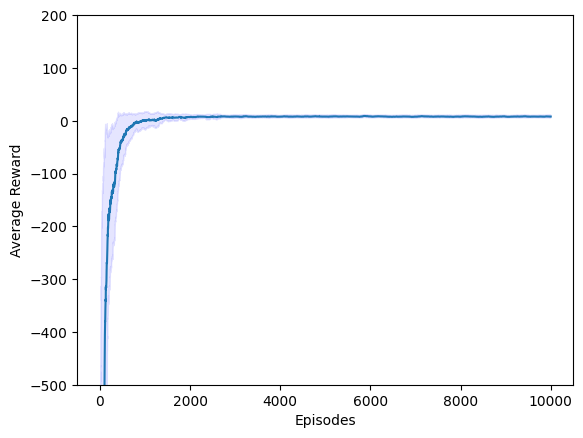

In [77]:
def plot_rewards(rewards):
    avg_rew = []
    std_dev = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=100)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
        std_dev.append(np.std(scores_window))
    plt.plot(avg_rew)
    plt.fill_between(range(len(avg_rew)), np.subtract(avg_rew, std_dev), np.add(avg_rew, std_dev), color='b', alpha=0.1)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-500, 200)  # Set the Y-axis range

plot_rewards(total_rewards)

In [78]:
print(np.mean(total_rewards[-100:]))

7.905582999999999


In [79]:
'''
Passenger IN TAXI => DESTINATION is the goal
'''
def plot_options(Q_option):
    PASSENGER_LOCATIONS = [0, 1, 2, 3, 4]
    PASSENGER_LOCATIONS_TEXT = ['R', 'G', 'Y', 'B', 'In Taxi']
    DESTINATIONS = [0, 1, 2, 3]
    DESTINATIONS_TEXT = ['R', 'G', 'Y', 'B']

    ACTIONS_OPTIONS = ['down', 'up', 'right', 'left', 'pickup', 'dropoff']

    fig, ax = plt.subplots(5, 4, figsize=(20, 20))

    for PASS_LOC in PASSENGER_LOCATIONS:
        for DEST in DESTINATIONS:
            Q_MAP = np.zeros((5, 5, 4))
            for i in range(5):
                for j in range(5):
                    state = ((5*i + j) * 5 + PASS_LOC) * 4 + DEST
                    Q_MAP[i, j] = Q_option[state]
            
            ax[int(PASS_LOC), int(DEST)].imshow(np.argmax(Q_MAP, axis=2), cmap='YlOrBr')
            ax[int(PASS_LOC), int(DEST)].set_title(f"Passenger: {PASSENGER_LOCATIONS_TEXT[int(PASS_LOC)]}, Destination: {DESTINATIONS_TEXT[int(DEST)]}")
            ax[int(PASS_LOC), int(DEST)].axis('off')

            ax[int(PASS_LOC), int(DEST)].axvline(x=0.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.5, ymin=1, ymax=0.6, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)

            # ax[int(PASS_LOC), int(DEST)].axvline(x=-0.5, ymin=1, ymax=0.6, color="red", linewidth=5)
            # ax[int(PASS_LOC), int(DEST)].axhline(xmin=-0.5, xmax=1, y=1, color="red", linewidth=5)
            # ax[int(PASS_LOC), int(DEST)].axvline(x=-0.5, ymin=1, ymax=0.6, color="red", linewidth=5)
            # ax[int(PASS_LOC), int(DEST)].axvline(x=-0.5, ymin=1, ymax=0.6, color="red", linewidth=5)

            for i in range(5):
                for j in range(5):
                    state = (5*i + j)*4 + int(PASS_LOC)*4 + int(DEST)
                    anno = ACTIONS_OPTIONS[np.argmax(Q_MAP[i,j])]
                    size='medium'
                    ax[int(PASS_LOC), int(DEST)].text(j , i, anno, ha='center', va='center', color='black', size=size)

    plt.show()

def plot_Q_values(Q_values):
    
    PASSENGER_LOCATIONS = [0, 1, 2, 3, 4]
    PASSENGER_LOCATIONS_TEXT = ['R', 'G', 'Y', 'B', 'In Taxi']
    DESTINATIONS = [0, 1, 2, 3]
    DESTINATIONS_TEXT = ['R', 'G', 'Y', 'B']

    ACTIONS_OPTIONS = ['down', 'up', 'right', 'left', 'pickup', 'dropoff', 'toR', 'toG', 'toY', 'toB']
    # ACTIONS_OPTIONS = ['down', 'up', 'right', 'left', 'pickup', 'dropoff', 'goRY', 'goG', 'goB']


    fig, ax = plt.subplots(5, 4, figsize=(20, 20))

    for PASS_LOC in PASSENGER_LOCATIONS:
        for DEST in DESTINATIONS:
            Q_MAP = np.zeros((5, 5, 10))
            for i in range(5):
                for j in range(5):
                    state = ((5*i + j) * 5 + PASS_LOC) * 4 + DEST
                    Q_MAP[i, j] = Q_values[state]
            
            ax[int(PASS_LOC), int(DEST)].imshow(np.argmax(Q_MAP, axis=2), cmap='YlOrBr')
            ax[int(PASS_LOC), int(DEST)].set_title(f"Passenger: {PASSENGER_LOCATIONS_TEXT[int(PASS_LOC)]}, Destination: {DESTINATIONS_TEXT[int(DEST)]}")
            ax[int(PASS_LOC), int(DEST)].axis('off')

            ax[int(PASS_LOC), int(DEST)].axvline(x=0.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.5, ymin=1, ymax=0.6, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)


            for i in range(5):
                for j in range(5):
                    state = (5*i + j)*4 + int(PASS_LOC)*4 + int(DEST)
                    anno = ACTIONS_OPTIONS[np.argmax(Q_MAP[i,j])]
                    size='medium'
                    ax[int(PASS_LOC), int(DEST)].text(j , i, anno, ha='center', va='center', color='black', size=size)

    plt.show()


In [80]:
print(Q_within_option)

[[[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [34.85157653  0.          0.          0.        ]
  ...
  [-0.99246602 -0.92320469 -0.85359531 -0.98098047]
  [-0.99625625 -1.10576318 -1.16874314 -1.01365859]
  [-0.99625625 -1.0130957  -0.95800937 -0.83828125]]

 [[ 0.          0.          0.          0.        ]
  [-0.4375     -0.70685691 27.77794466 -0.499375  ]
  [ 0.          0.          0.          0.        ]
  ...
  [ 0.          1.80734375  0.         -0.25      ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [-0.4375     -0.68640625 -0.4375     -0.499375  ]
  ...
  [ 0.         -0.25        0.         -0.25      ]
  [-0.68640625 -0.74546875 -0.499375    1.10953931]
  [-0.74812656 -0.94996601 -0.74812656 -0.7944168 ]]

 [[ 0.          0.          0.          

# Option Policy Plots

In [81]:
Q_within_option[0][:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [34.85157653,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [18.98927626,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 18.99660694,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  4.75      ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  4.75      ]])

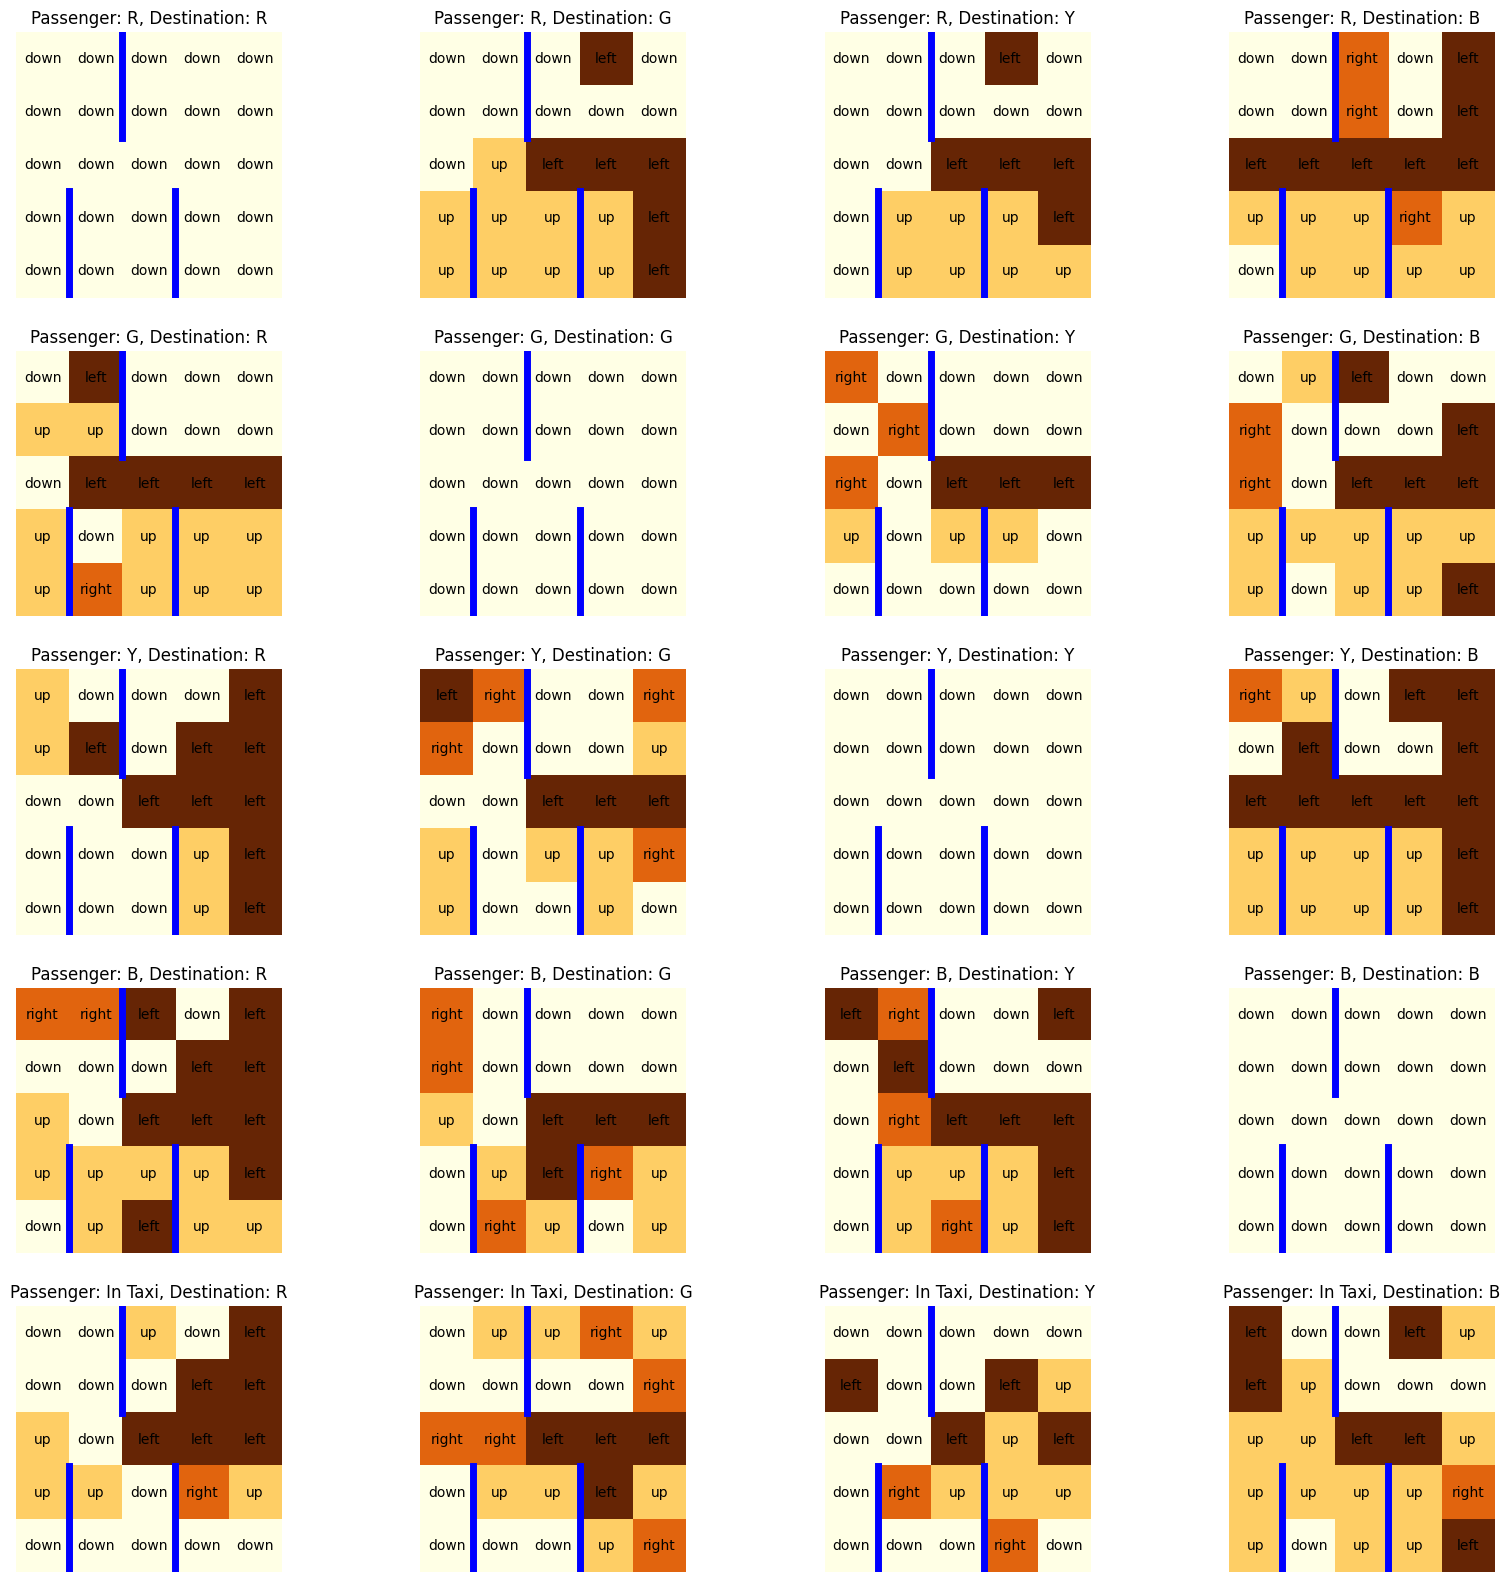

In [82]:
plot_options(Q_within_option[0])

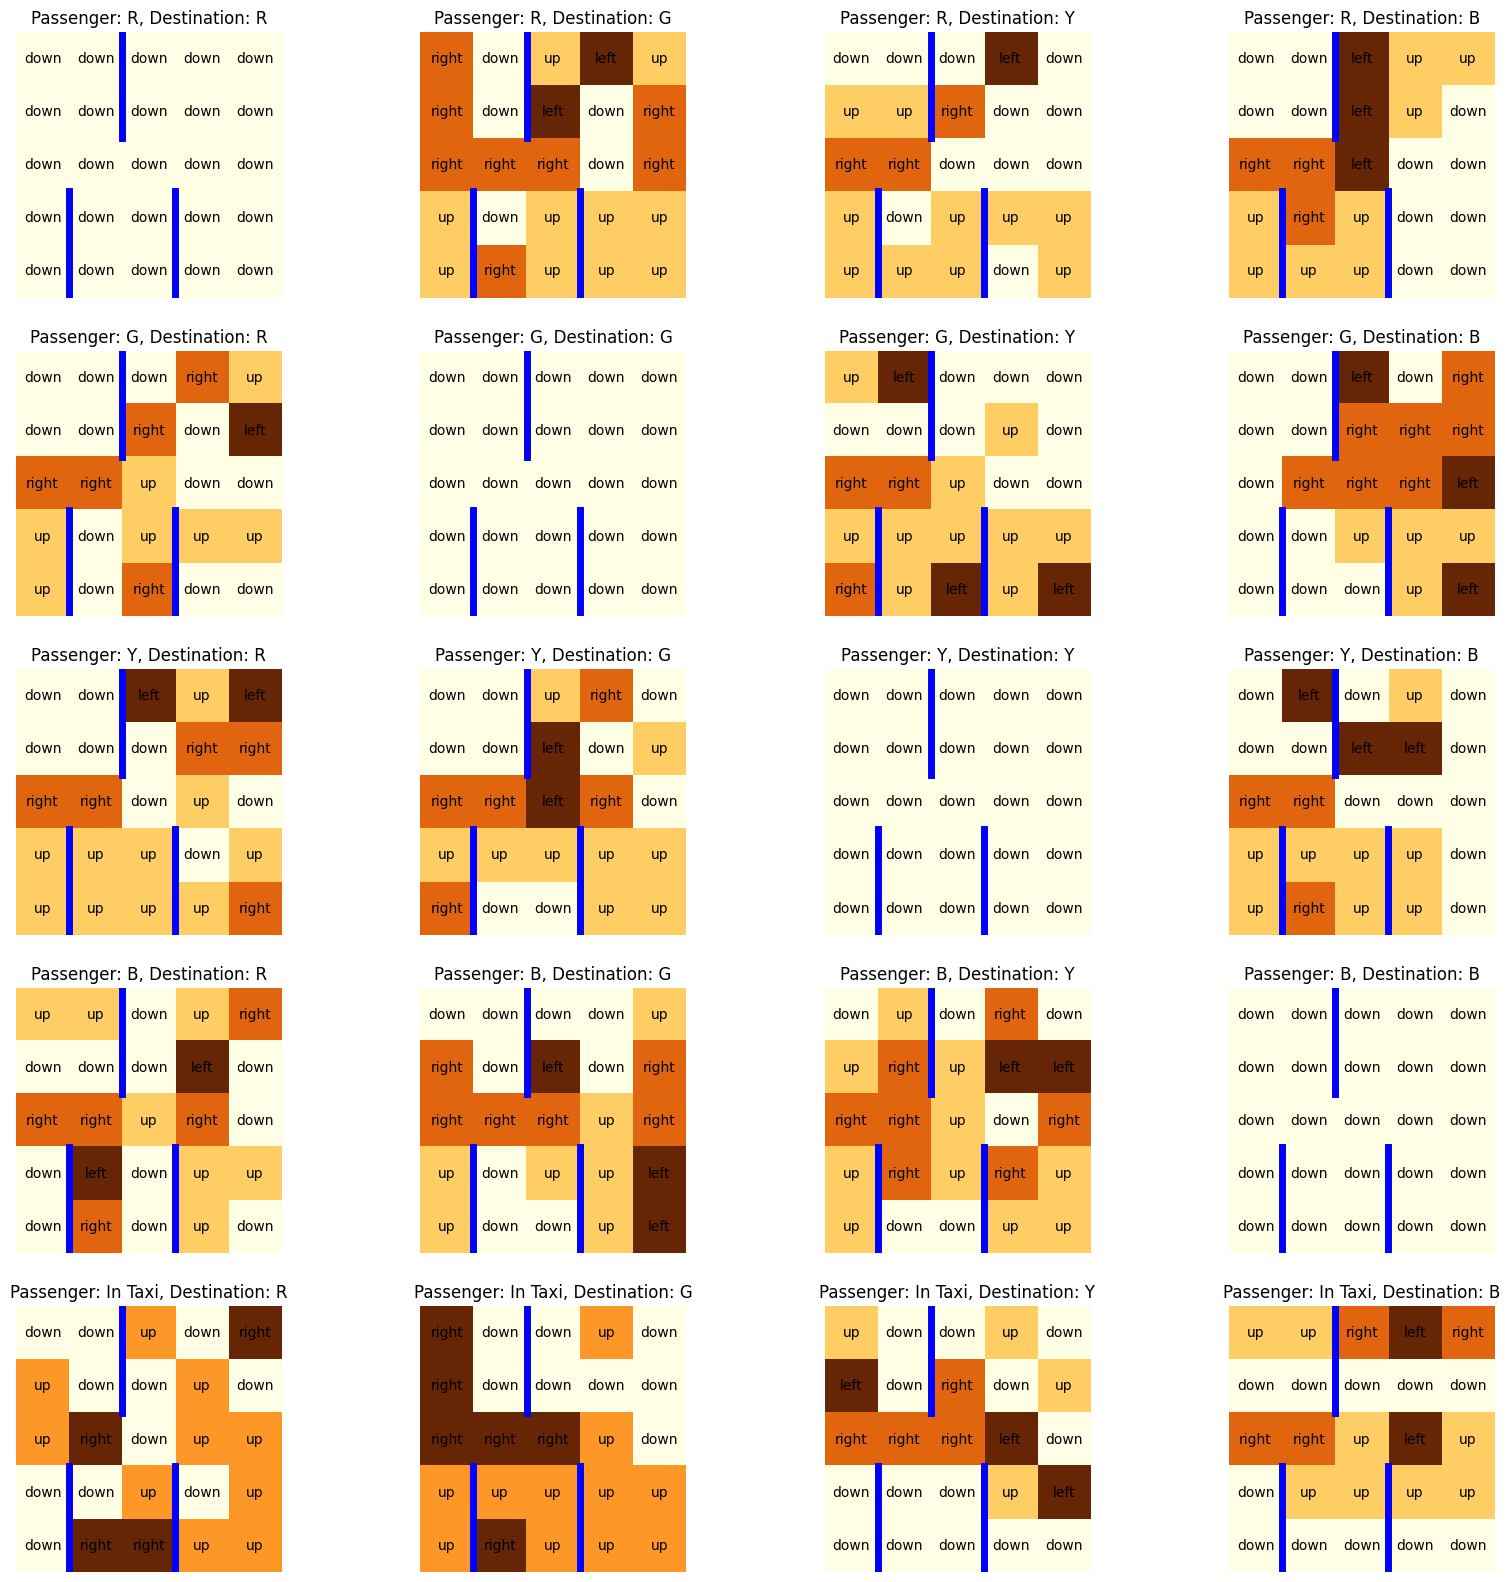

In [83]:
plot_options(Q_within_option[1])

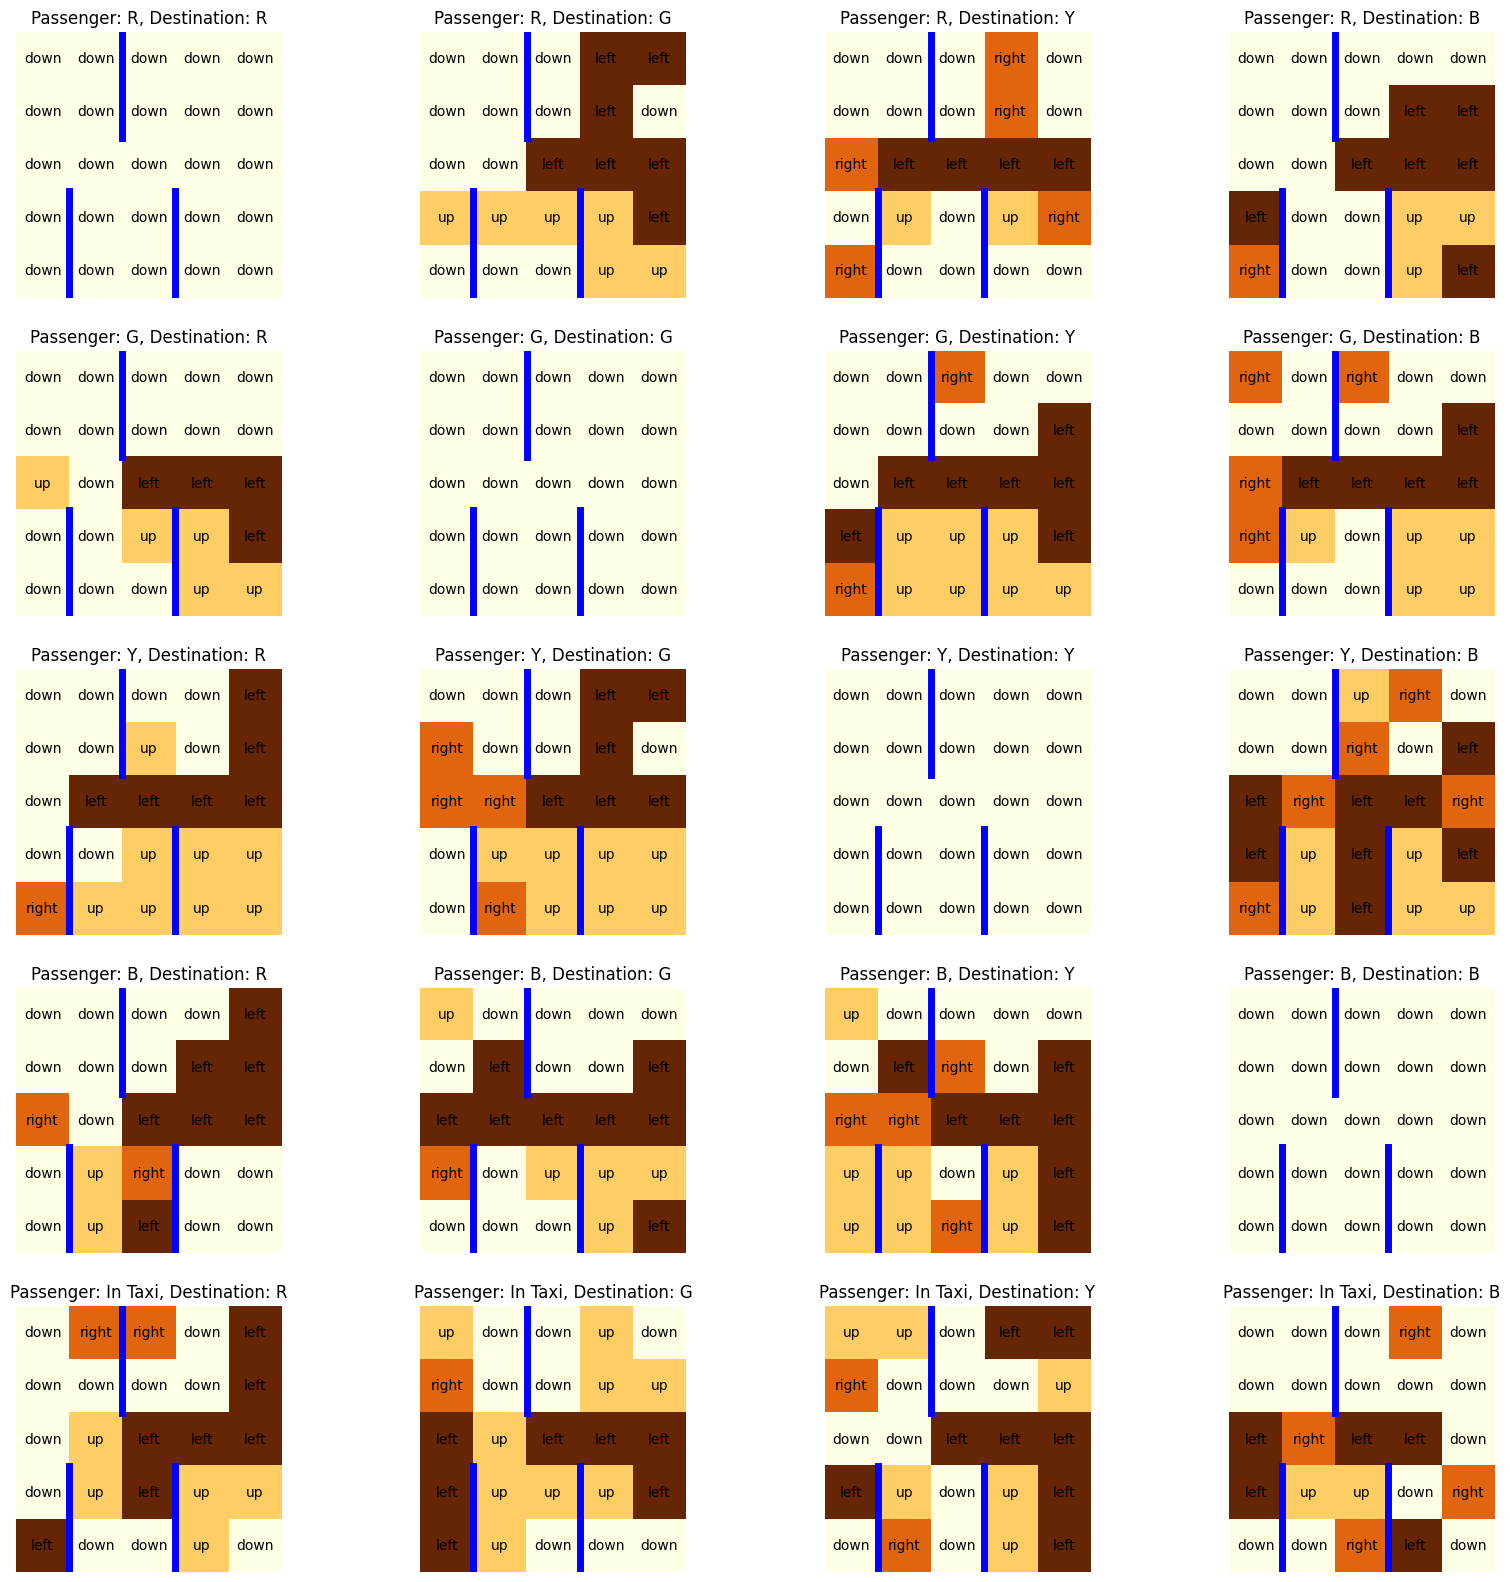

In [84]:
plot_options(Q_within_option[2])

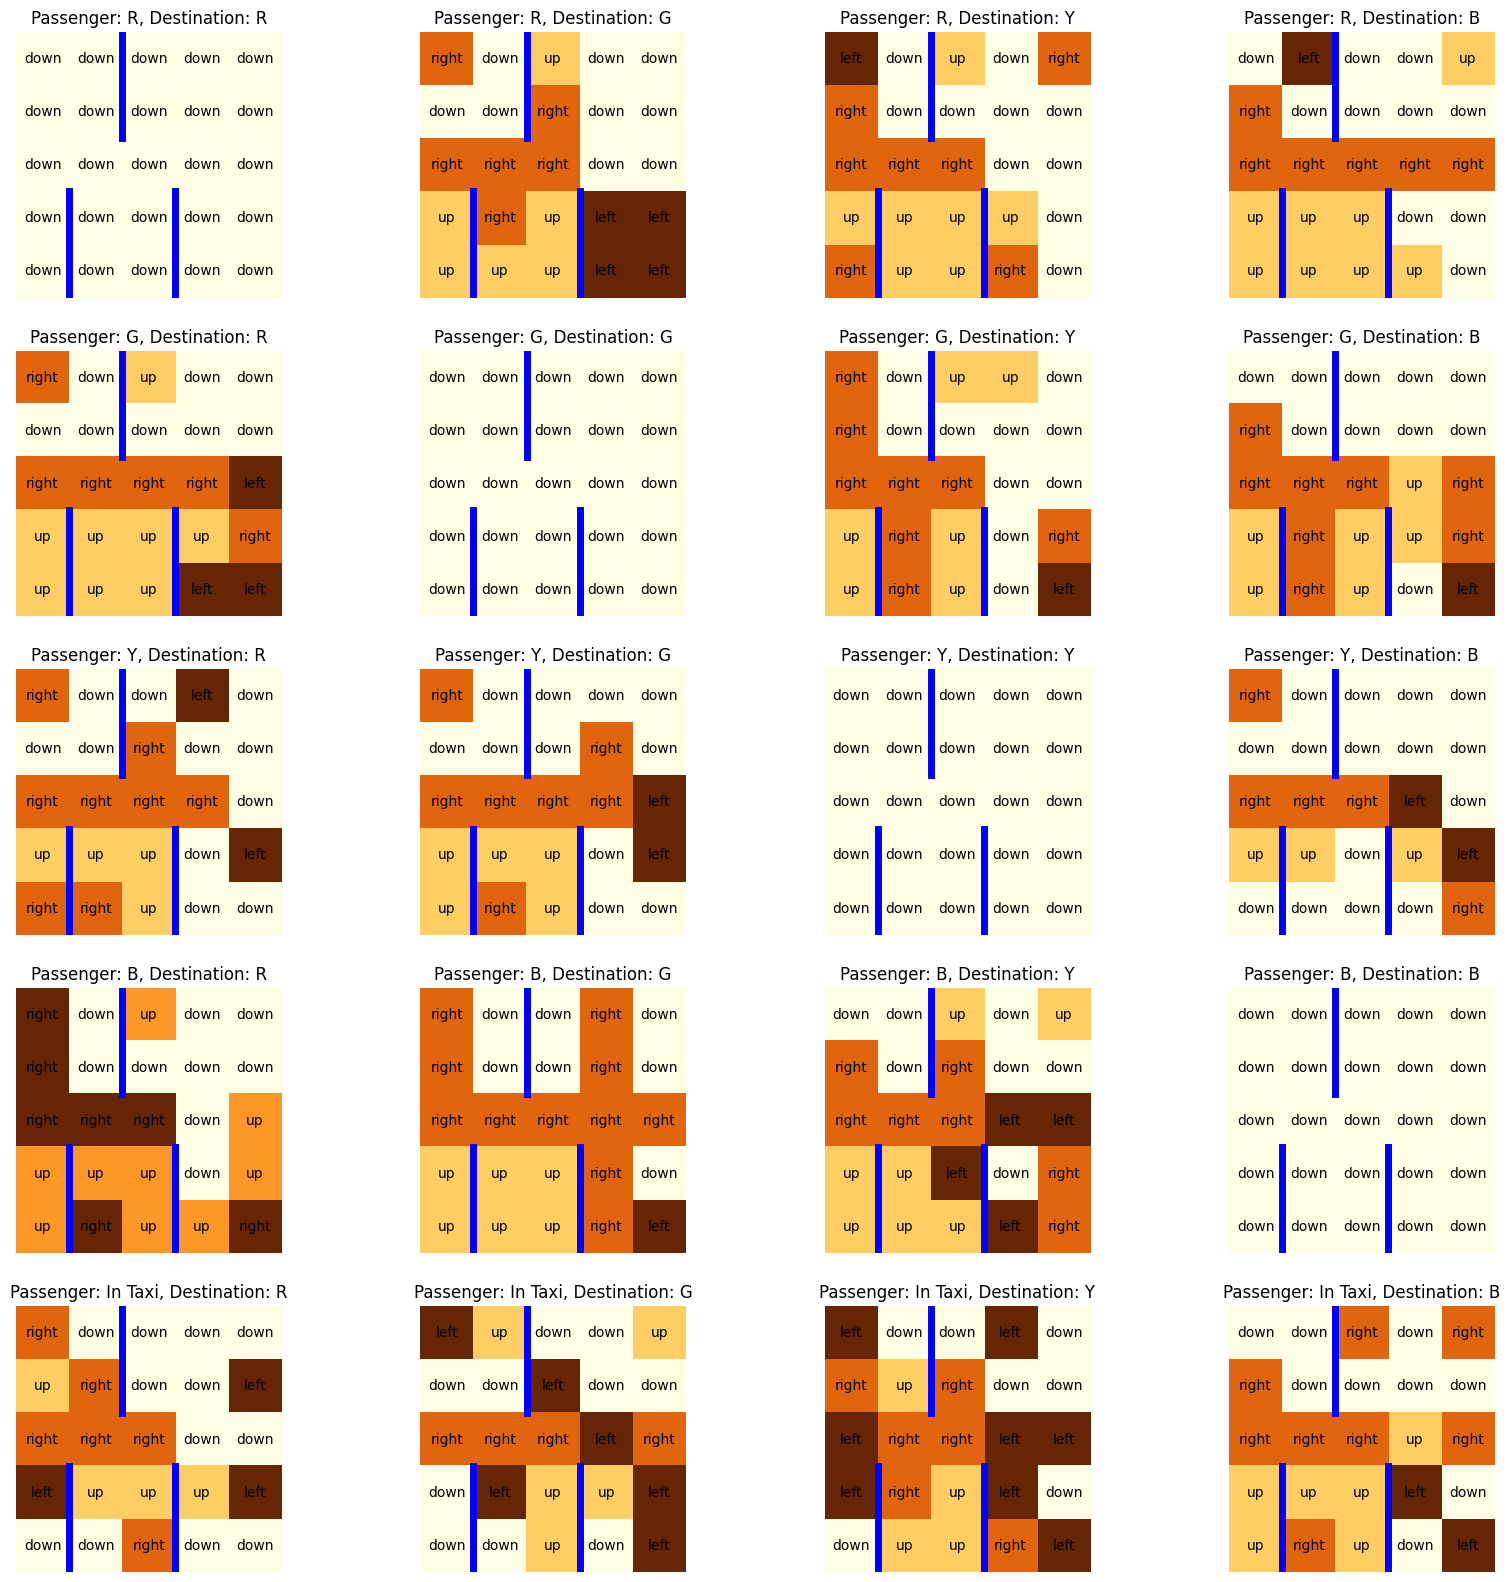

In [85]:
plot_options(Q_within_option[3])

# Main Policy Plots

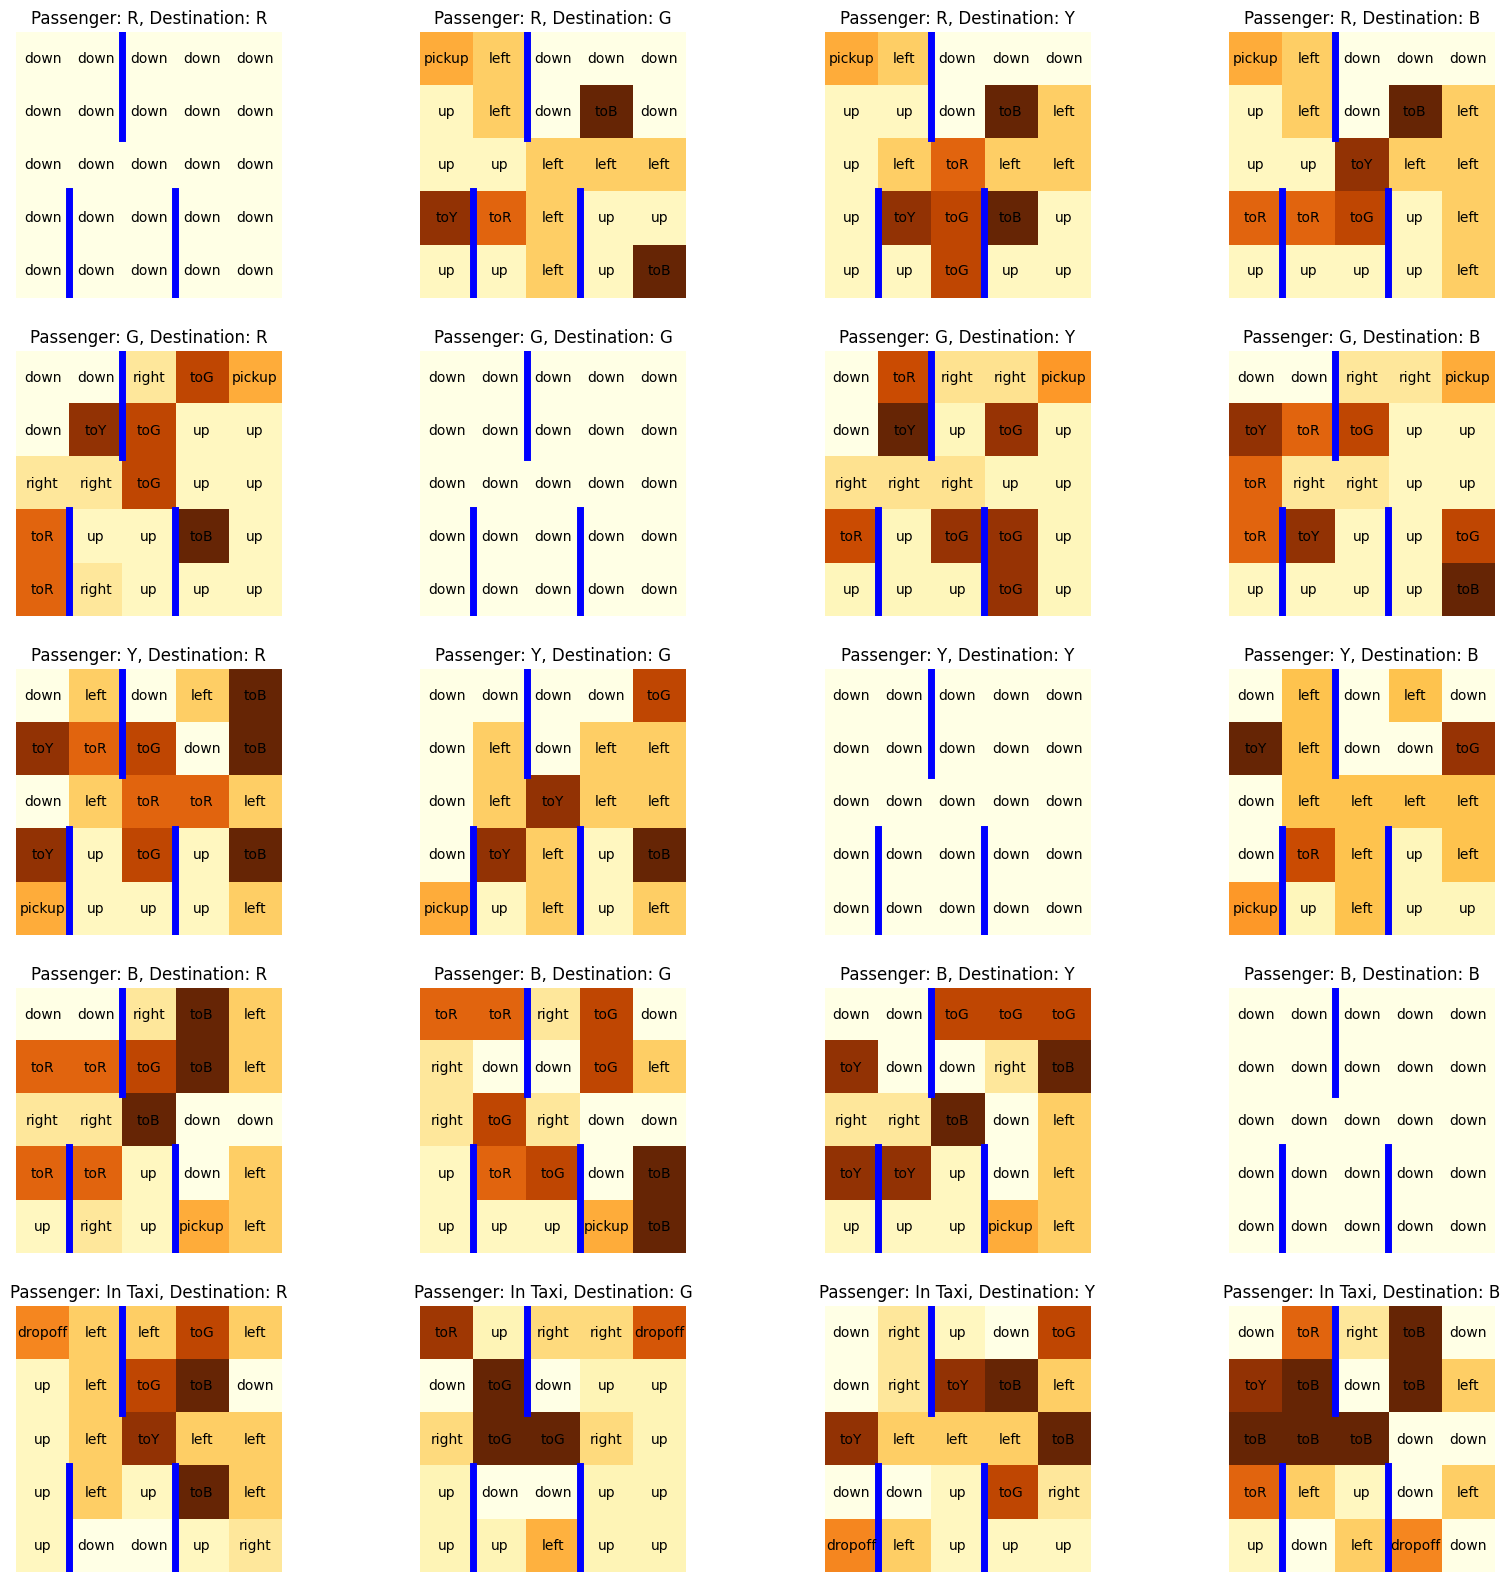

In [86]:
plot_Q_values(Q_select_option)